<a href="https://colab.research.google.com/github/Shisiajoy/MACHINE-LEARNING/blob/main/BreastcancerCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp


from PIL import Image
from IPython.display import display


from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, Dropout, BatchNormalization,Input , Flatten
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
# Set up Kaggle API credentials
#os.environ['KAGGLE_USERNAME'] = 'shisiajoy'
#os.environ['KAGGLE_KEY'] = '1dd180f469c6368d77b117006c289cd1'




In [8]:
from google.colab import userdata

# Access the secret using the correct secret name 'shisiajoy'
secret_value = userdata.get('shisiajoy')

# Print or use the secret as needed
print(secret_value)


1dd180f469c6368d77b117006c289cd1


In [9]:
pip install pillow


In [10]:
# Install Kaggle API if not already installed
!pip install kaggle


In [11]:
!kaggle datasets download -d gauravduttakiit/rsna-screening-mammography-breast-cancer-detection


Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/rsna-screening-mammography-breast-cancer-detection
License(s): CC0-1.0
 99% 996M/0.98G [00:12<00:00, 129MB/s]
100% 0.98G/0.98G [00:12<00:00, 86.6MB/s]


In [12]:
!unzip rsna-screening-mammography-breast-cancer-detection.zip -d /content/rsna_mammography_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/rsna_mammography_dataset/output/train/63617_1917877119.png  
  inflating: /content/rsna_mammography_dataset/output/train/63617_887426674.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1186739164.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1657034655.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_335778602.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_625719002.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_1154699412.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_549972940.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_599167493.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_939566995.png  
  inflating: /content/rsna_mammography_dataset/output/train/63627_1214214469.png  
  inflating: /content/rsna_mammography_dat

In [13]:
#path to csv file
traininfo = pd.read_csv("/content/rsna_mammography_dataset/train.csv")

In [14]:
traininfo.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10006,462822612,L,CC,61.0,0,29,10006_L,0
1,2,10006,1459541791,L,MLO,61.0,0,29,10006_L,0
2,2,10006,1864590858,R,MLO,61.0,0,29,10006_R,0
3,2,10006,1874946579,R,CC,61.0,0,29,10006_R,0
4,2,10011,220375232,L,CC,55.0,0,21,10011_L,0


In [16]:
#path image folder
image_folder_path = '/content/rsna_mammography_dataset/output/train'

Trying to load: /content/rsna_mammography_dataset/output/train/10006_1459541791.png


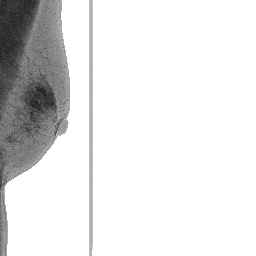

In [21]:
def load_image(patient_id, image_id, image_folder_path):
    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(image_folder_path, image_filename)
    print(f"Trying to load: {image_path}")  # Debugging statement
    if os.path.exists(image_path):
        return Image.open(image_path)
    else:
        print(f"Image {image_filename} not found.")
        return None

# Test with a single image
test_patient_id = '10006'  # Replace with a valid patient_id
test_image_id = '1459541791'  # Replace with a valid image_id
image = load_image(test_patient_id, test_image_id, image_folder_path)
if image:
    display(image)


Displaying a cancer image:


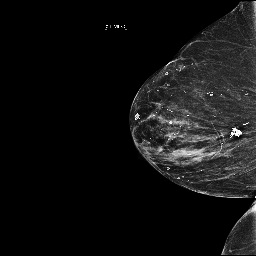

Displaying a no-cancer image:


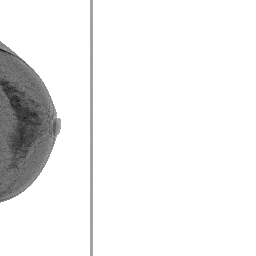

In [23]:
def load_image(patient_id, image_id, image_folder_path):
    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(image_folder_path, image_filename)
    if os.path.exists(image_path):
        return Image.open(image_path)
    else:
        print(f"Image {image_filename} not found.")
        return None

# Group images by cancer label
def group_images_by_cancer(df, image_folder_path):
    grouped_images = {'cancer': [], 'no_cancer': []}

    # Assuming cancer column contains binary values (0 or 1)
    for _, row in df.iterrows():
        patient_id = row['patient_id']
        image_id = row['image_id']
        cancer_label = row['cancer']  # Use 'cancer' column for labeling

        image = load_image(patient_id, image_id, image_folder_path)
        if image:
            if cancer_label == 1:  # Assuming 1 indicates 'cancer'
                grouped_images['cancer'].append(image)
            elif cancer_label == 0:  # Assuming 0 indicates 'no cancer'
                grouped_images['no_cancer'].append(image)

    return grouped_images

# Test grouping images
grouped_images = group_images_by_cancer(traininfo, image_folder_path)

# Display a sample image from each group
if grouped_images['cancer']:
    print("Displaying a cancer image:")
    display(grouped_images['cancer'][0])
if grouped_images['no_cancer']:
    print("Displaying a no-cancer image:")
    display(grouped_images['no_cancer'][0])


### ORGANIZE TEST DATA INTO 'CANCER' AND 'NO_CANCER'

In [25]:
# Define paths
base_path = '/content/rsna_mammography_dataset/output/train'
cancer_path = os.path.join(base_path, 'cancer')
no_cancer_path = os.path.join(base_path, 'no_cancer')

# Create the cancer and no_cancer directories
os.makedirs(cancer_path, exist_ok=True)
os.makedirs(no_cancer_path, exist_ok=True)

# Function to move images to respective directories
def organize_images(row):
    patient_id = row['patient_id']
    image_id = row['image_id']
    cancer_label = row['cancer']  # Assuming 1 indicates cancer, 0 indicates no cancer

    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(base_path, image_filename)

    # Check if the image exists
    if os.path.exists(image_path):
        if cancer_label == 1:
            shutil.move(image_path, os.path.join(cancer_path, image_filename))
        else:
            shutil.move(image_path, os.path.join(no_cancer_path, image_filename))
    else:
        print(f"Image {image_filename} not found in {base_path}.")

# Apply the function to organize images
traininfo.apply(organize_images, axis=1)
print("Images have been organized into 'cancer' and 'no_cancer' folders.")


Images have been organized into 'cancer' and 'no_cancer' folders.


### SPLIT DATA INTO TRAINING AND VALIDATION

In [37]:
ImageDataGenerator(rescale=1./255 , validation_split =  0.2)

- SET UP PARAMETERS

In [30]:
datagenerator = ImageDataGenerator(
    rotation_range=20,
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [49]:
traingenerator = datagenerator.flow_from_directory(base_path , target_size = (150 ,150), batch_size = 32 , class_mode = 'binary' ,subset = 'training', color_mode='grayscale')

Found 43766 images belonging to 2 classes.


In [50]:
validationgenerator = datagenerator.flow_from_directory(base_path , target_size = (150 ,150), batch_size = 32 , class_mode = 'binary' ,subset = 'validation', color_mode='grayscale')

Found 10940 images belonging to 2 classes.


### MODELING

In [51]:
# Define the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (6, 6), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 145, 145, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 70, 70, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 33, 33, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,097 (16.36 MB)

 Trainable params: 4,288,097 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### TRAINING

In [52]:
model.fit(traingenerator, validation_data=validationgenerator,epochs = 5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2527s 2s/step - accuracy: 0.9761 - loss: 0.3699 - val_accuracy: 0.9789 - val_loss: 0.1028
Epoch 2/5
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2484s 2s/step - accuracy: 0.9791 - loss: 0.1072 - val_accuracy: 0.9789 - val_loss: 0.1165
Epoch 3/5
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2578s 2s/step - accuracy: 0.9780 - loss: 0.1112 - val_accuracy: 0.9789 - val_loss: 0.1031
Epoch 4/5
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2477s 2s/step - accuracy: 0.9785 - loss: 0.1071 - val_accuracy: 0.9789 - val_loss: 0.1022
Epoch 5/5
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2480s 2s/step - accuracy: 0.9781 - loss: 0.1113 - val_accuracy: 0.9789 - val_loss: 0.1020
